In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np

In [2]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bitstrings to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()


def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

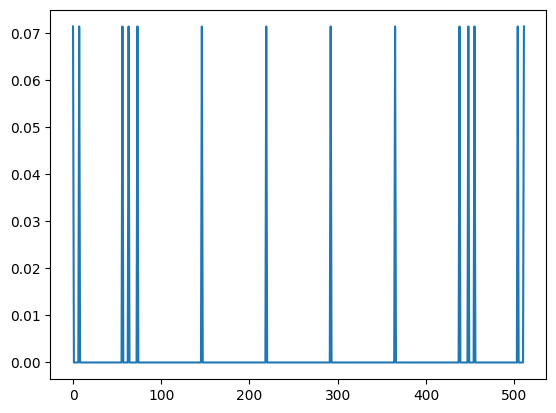

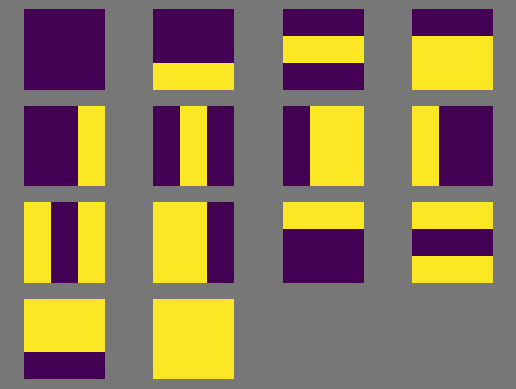

In [3]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

basis = binary_basis(geometry)

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (4, 4)
plot_bs(samples, size)

In [6]:
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
beta = 1e3
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 5000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
data = jax.device_put(samples)

In [7]:
samples = np.random.multivariate_normal(np.array([0., 0.]), np.eye(2), 14)
data = jax.device_put(samples)

In [8]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()

def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=48);

param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(jnp.linalg.norm(s1 - s2)) / bandwidth_sq)

data_probs = jnp.ones(len(data)) / len(data)

def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)
train_keys = random.split(train_key, n_steps - 1)
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

q0: -----H-----Rx[0]---Ry[8]-----◯---------------------------------------------Rx[16]--Ry[24]------------◯-----------
                                 |                                                                       |           
q1: -----H-----Rx[1]---Ry[9]-----CZ------◯-------------------------------------Rx[17]--Ry[25]------------CZ------◯---
                                         |                                                                       |   
q2: -----H-----Rx[2]---Ry[10]------------CZ------◯-----------------------------Rx[18]--Ry[26]--------------------CZ--
                                                 |                                                                   
q3: -----H-----Rx[3]---Ry[11]--------------------CZ------◯---------------------Rx[19]--Ry[27]------------------------
                                                         |                                                           
q4: -----H-----Rx[4]---Ry[12]---------------------------

### Training with SGLD

In [9]:
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)
train_keys = random.split(train_key, n_steps - 1)
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

for step in range(1, n_steps):
    cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1])
    cost_vals = cost_vals.at[step - 1].set(cost_val)

    stepsize = get_stepsize(step)

    new_param = (
            params[step - 1]
            - stepsize * cost_grad
            + jnp.sqrt(2 * stepsize / beta)
            * random.normal(train_keys[step - 1], shape=(n_params,))
    )
    params = params.at[step].set(new_param)

    print("Iteration:", step, "\tCost:", cost_val, end="\r")

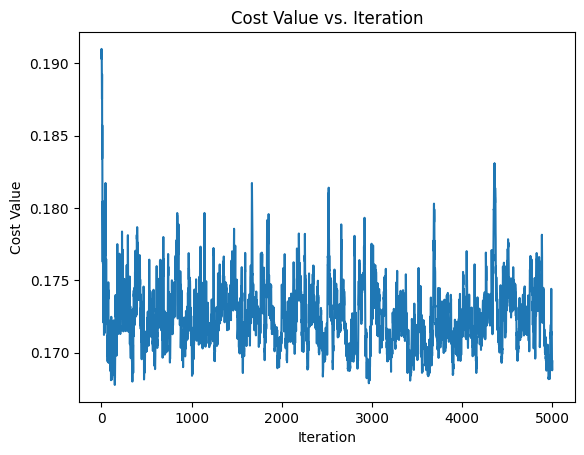

In [8]:
# Plot the cost values
plt.figure()
plt.plot(range(1, n_steps), cost_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost Value")
plt.title("Cost Value vs. Iteration")
plt.show()

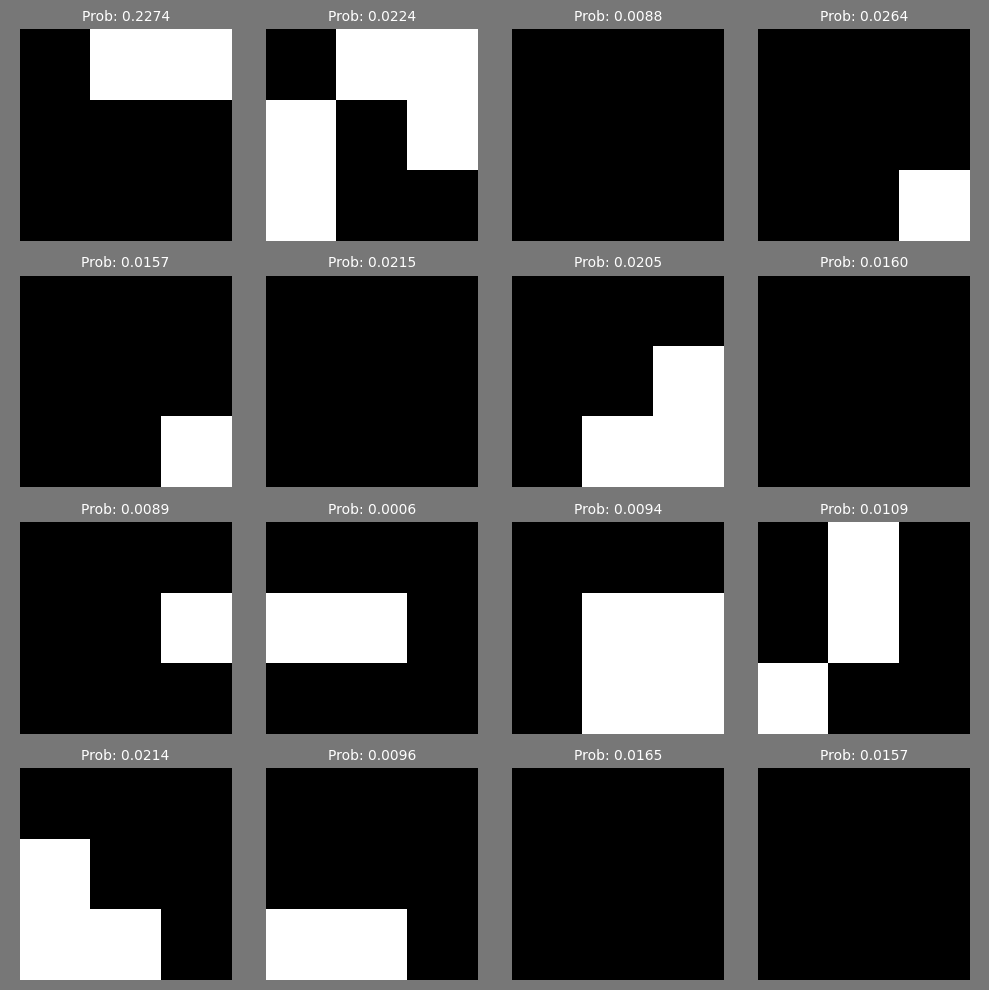

In [10]:
# Get the index of the minimum cost value
min_cost_idx = np.argmin(cost_vals)

# Get the final parameters corresponding to the minimum cost
final_params = params[min_cost_idx + 1] 

def plot_bs(samples, size, probabilities):
    plt.figure(figsize=(10, 10), facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i * size[1] + j == len(samples):
                break
            ax = plt.subplot(gs[i, j])
            ax.imshow(samples[i * size[1] + j], vmin=0, vmax=1, cmap='gray')
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(f"Prob: {probabilities[i * size[1] + j]:.4f}", fontsize=10, color='white')

    plt.tight_layout()
    plt.show()

# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')

    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)

    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))

    # Convert probabilities to a numpy array for use with numpy's random.choice
    probabilities_np = np.array(probabilities)

    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)

    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])

    return samples

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Get the corresponding probabilities
final_st = param_to_st(final_params)
probabilities = jnp.square(jnp.abs(final_st.flatten()))
probabilities_np = np.array(probabilities)

# Visualize the generated samples with probabilities
plot_bs(final_samples, size=(4, 4), probabilities=probabilities_np)

In [11]:
import time

def G(p, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    q = q + h * M_inv @ p
    return q,p,xi

def B_step(q,p,xi,h,force, params_for_sgada):
    p = p + h * force(q) 
    return q,p,xi

def O_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, _ = params_for_sgada
    
    term1 = np.exp(-xi*h) * p
    term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
    p = term1 + term2
    return q,p,xi

def D_step(q,p,xi,h, params_for_sgada):
    from jax import numpy as jnp
    import numpy as np
    xi = xi + h * G(p, params_for_sgada)
    return q,p,xi

def ld_BADODAB(q,p,xi,h,force, params_for_sgada):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force,params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = O_step(q,p,xi,h,   params_for_sgada)
    q, p, xi = D_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = A_step(q,p,xi,h/2, params_for_sgada)
    q, p, xi = B_step(q,p,xi,h/2,force, params_for_sgada)

    return q, p, xi





def run_simulation_SGAdL(alpha, q0, p0, xi0,step_function,force,hyperparameters,train_keys):
    #q0, p0, xi0, Nsteps, h, step_function, force):
    h, M, mu_inv, N_d, beta, sigma, sigma_a, n_steps, n_qubits, circuit_depth, batch_size = hyperparameters.values()

    bar_length = 30
    
    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    M_inv = M
    kBT     = 1 / beta
    params_for_sgada = (M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a, batch_size)

    
    start_time = time.time()  # Record the start time

    for n in range(n_steps):
        
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])

        # Add noise to the cost_grad
        noise = random.normal(train_keys[n - 1], shape=cost_grad.shape, dtype=jnp.float32)
        cost_grad = cost_grad + alpha * noise
        
        
        q,p,xi = step_function(q, p, xi, h, force, params_for_sgada)

        cost_vals.append(cost_val)
        

        q_traj += [q]
        p_traj += [p]
        xi_traj += [xi]
        
        progress = (n+1) / n_steps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        
        elapsed_time = time.time() - start_time  # Compute the elapsed time
        remaining_time = (elapsed_time / (n + 1)) * (n_steps - n - 1)  # Estimate the remaining time

        
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {n+1}/{n_steps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')    
    print()  # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time  # Compute the total run time
    
    return q_traj, p_traj, xi_traj, cost_vals, total_run_time

In [24]:
h_step_size = 1
stochastic_flag = True
qubit = 9
depth = 5
n_qubits = 9
circuit_depth = 5
beta = 1000
alpha = 0
n_steps = 20000
batch_size = 200
mu_inv = 10
sigma_a =0.1 

random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
init_rad = 0.001 / jnp.pi


sgadl_hyperparams = {
    'h': h_step_size, 'M': None, 'mu_inv': mu_inv, 'N_d': 1., 'beta': beta, 'sigma': 1., 'sigma_a': sigma_a,
    'n_steps': n_steps, 'n_qubits': qubit, 'circuit_depth': None, 'batch_size': batch_size
}

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
data_probs = jnp.ones(len(data)) / len(data)
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2

# if stochastic_flag:
#     param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd_stochastic(param, param_to_st, batch_size)))
# else:
#     param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd(param, param_to_st)))
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

train_keys = random.split(train_key, sgadl_hyperparams['n_steps'] - 1)

init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)

# Update hyperparameters with the current n_qubits and circuit_depth
sgadl_hyperparams['M'] = jnp.eye(n_params)

# Run SGADA model
sgada_output, sgada_p_traj, sgada_xi_traj, sgada_cost_vals, sgada_total_run_time = run_simulation_SGAdL(
    alpha, init_param, np.random.randn(n_params), 0.0, ld_BADODAB, (lambda q: -param_to_mmd_and_grad(q)[1]), sgadl_hyperparams, train_keys
)

model_SGAdL = {
    'params': sgada_output,
    'cost_vals': sgada_cost_vals,
    'run_time': sgada_total_run_time,
    'p_traj': sgada_p_traj,
    'xi_traj': sgada_xi_traj
}

# # Save results to files
# filename = f"results_bars.pkl"
# filepath = os.path.join(output_folder, filename)

# results = {
#     'sgadl': model_SGAdL
# }

# with open(filepath, 'wb') as f:
#     pickle.dump(results, f)
    
# print(f"Results saved to {filepath}")

# # Plot the cost values
# plt.figure()

Progress: |██████████████████████████████| 100.00% | Iteration: 20000/20000 | Cost: 0.086712 | Elapsed Time: 217.70s | Estimated Remaining Time: 0.00ss


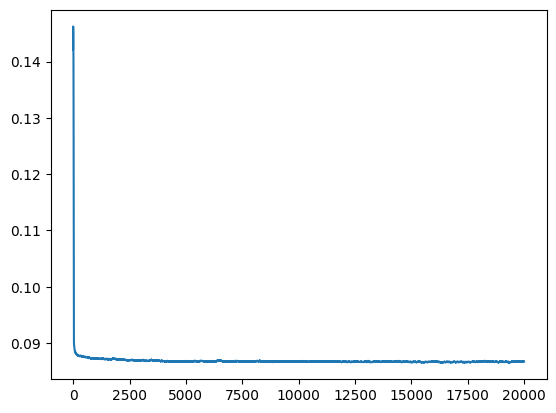

In [25]:
plt.plot(sgada_cost_vals)

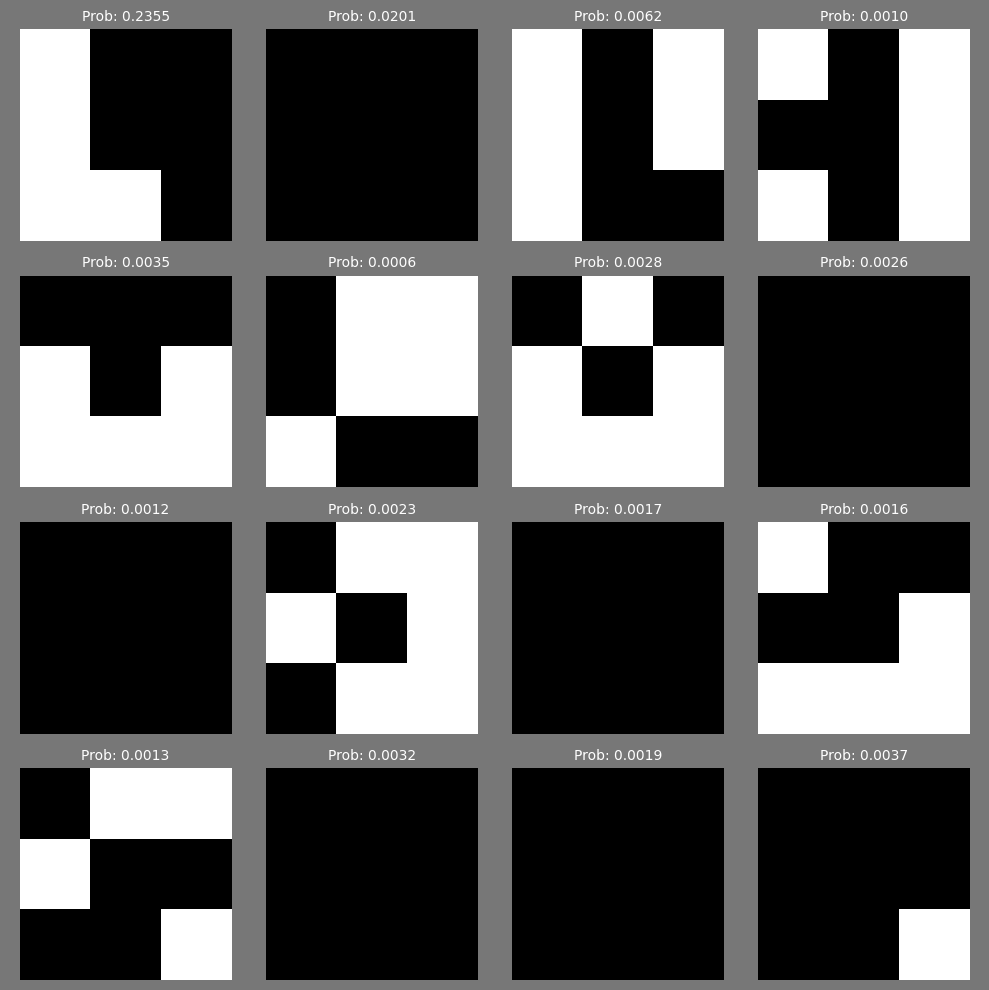

In [26]:
# Get the index of the minimum cost value
min_cost_idx = np.argmin(sgada_cost_vals)

# Get the final parameters corresponding to the minimum cost
final_params = sgada_output[min_cost_idx + 1] 

def plot_bs(samples, size, probabilities):
    plt.figure(figsize=(10, 10), facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i * size[1] + j == len(samples):
                break
            ax = plt.subplot(gs[i, j])
            ax.imshow(samples[i * size[1] + j], vmin=0, vmax=1, cmap='gray')
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(f"Prob: {probabilities[i * size[1] + j]:.4f}", fontsize=10, color='white')

    plt.tight_layout()
    plt.show()

# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')

    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)

    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))

    # Convert probabilities to a numpy array for use with numpy's random.choice
    probabilities_np = np.array(probabilities)

    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)

    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])

    return samples

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Get the corresponding probabilities
final_st = param_to_st(final_params)
probabilities = jnp.square(jnp.abs(final_st.flatten()))
probabilities_np = np.array(probabilities)

# Visualize the generated samples with probabilities
plot_bs(final_samples, size=(4, 4), probabilities=probabilities_np)

/tmp/ipykernel_3551/1319756114.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)  # Adjust the padding between plots


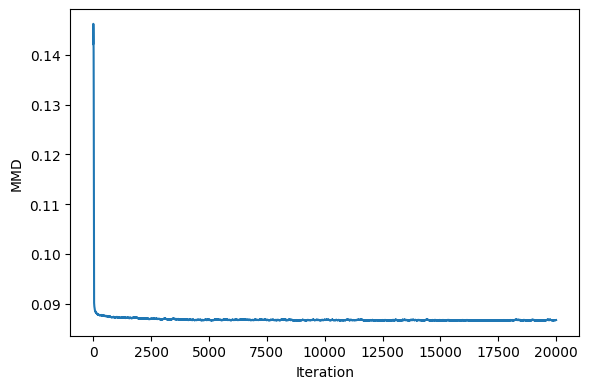

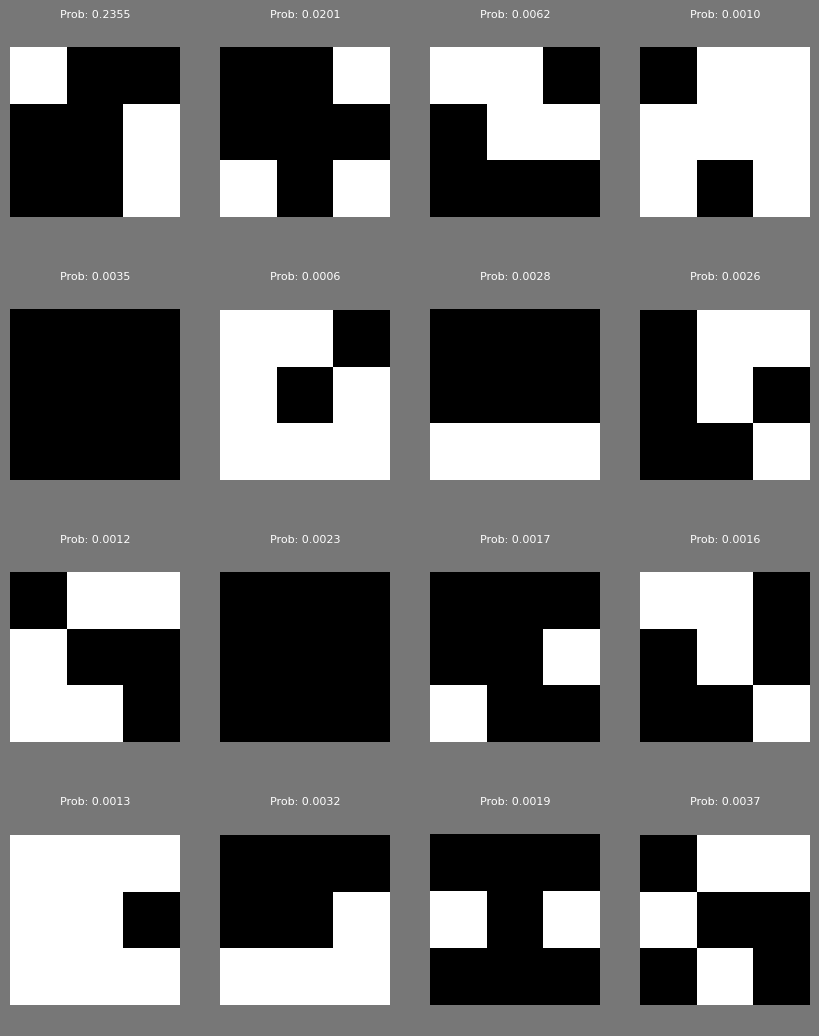

In [63]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the "images" folder if it doesn't exist
if not os.path.exists("images"):
    os.makedirs("images")

# MMD plot
fig1 = plt.figure(figsize=(6, 4))
ax1 = fig1.gca()
ax1.plot(sgada_cost_vals)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("MMD")
plt.tight_layout()
plt.savefig("images/BAS_3x3_MMD.png", bbox_inches='tight')

# Get the index of the minimum cost value
min_cost_idx = np.argmin(sgada_cost_vals)

# Get the final parameters corresponding to the minimum cost
final_params = sgada_output[min_cost_idx + 1]

# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')
    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)
    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))
    # Convert probabilities to a numpy array for use with numpy's random.choice
    probabilities_np = np.array(probabilities)
    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)
    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])
    return samples

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Get the corresponding probabilities
final_st = param_to_st(final_params)
probabilities = jnp.square(jnp.abs(final_st.flatten()))
probabilities_np = np.array(probabilities)

# Generated samples with probabilities
fig2 = plt.figure(figsize=(8, 10), facecolor='#777777')  # Adjust the figure size
size = (4, 4)
spacing = 0.05  # Adjust the spacing between probability plots
plot_size = (1 - spacing * (size[0] - 1)) / size[0]  # Calculate the size of each probability plot

for i in range(size[0]):
    for j in range(size[1]):
        if i * size[1] + j == len(final_samples):
            break
        ax = fig2.add_axes([j * (plot_size + spacing), (1 - (i + 1) * (plot_size + spacing) - spacing), plot_size, plot_size])
        ax.imshow(final_samples[i * size[1] + j], vmin=0, vmax=1, cmap='gray')
        ax.axis('equal')
        ax.axis('off')
        ax.set_title(f"Prob: {probabilities_np[i * size[1] + j]:.4f}", fontsize=8, color='white')

plt.tight_layout(pad=1.0)  # Adjust the padding between plots
plt.savefig("images/BAS_3x3_Samples.png", bbox_inches='tight')
plt.show()

2024-04-19 11:45:22.047731: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_param_to_mmd] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-19 11:45:31.256818: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m18.686403998s

********************************
[Compiling module jit_param_to_mmd] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Progress: |██████████████████████████████| 100.00% | Iteration: 20000/20000 | Cost: 0.089986 | Elapsed Time: 1151.47s | Estimated Remaining Time: 0.00sss


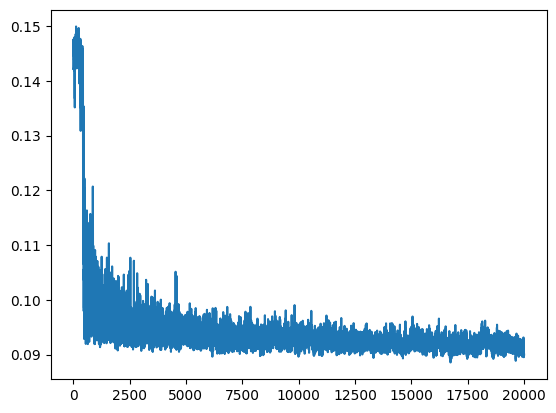

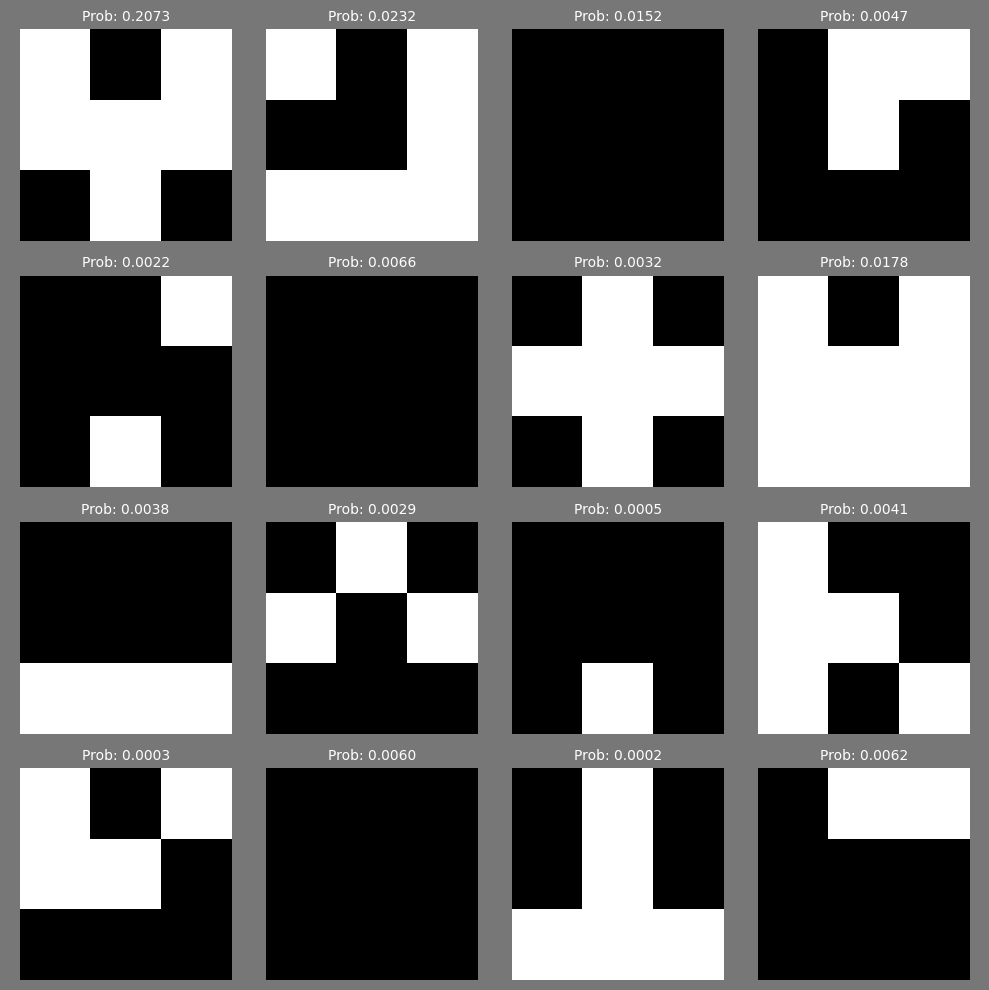

In [23]:
h_step_size = 1
stochastic_flag = True
qubit = 9
depth = 5
n_qubits = 9
circuit_depth = 5
beta = 1000
alpha = 0
n_steps = 20000
batch_size = 200
mu_inv = 1
sigma_a =1

random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
init_rad = 0.001 / jnp.pi


sgadl_hyperparams = {
    'h': h_step_size, 'M': None, 'mu_inv': mu_inv, 'N_d': 1., 'beta': beta, 'sigma': 1., 'sigma_a': sigma_a,
    'n_steps': n_steps, 'n_qubits': qubit, 'circuit_depth': None, 'batch_size': batch_size
}

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
data_probs = jnp.ones(len(data)) / len(data)
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2

# if stochastic_flag:
#     param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd_stochastic(param, param_to_st, batch_size)))
# else:
#     param_to_mmd_and_grad = jit(value_and_grad(lambda param: param_to_mmd(param, param_to_st)))
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

train_keys = random.split(train_key, sgadl_hyperparams['n_steps'] - 1)

init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)

# Update hyperparameters with the current n_qubits and circuit_depth
sgadl_hyperparams['M'] = jnp.eye(n_params)

# Run SGADA model
sgada_output, sgada_p_traj, sgada_xi_traj, sgada_cost_vals, sgada_total_run_time = run_simulation_SGAdL(
    alpha, init_param, np.random.randn(n_params), 0.0, ld_BADODAB, (lambda q: -param_to_mmd_and_grad(q)[1]), sgadl_hyperparams, train_keys
)

model_SGAdL = {
    'params': sgada_output,
    'cost_vals': sgada_cost_vals,
    'run_time': sgada_total_run_time,
    'p_traj': sgada_p_traj,
    'xi_traj': sgada_xi_traj
}

plt.plot(sgada_cost_vals)
plt.show()

# Get the index of the minimum cost value
min_cost_idx = np.argmin(sgada_cost_vals)

# Get the final parameters corresponding to the minimum cost
final_params = sgada_output[min_cost_idx + 1] 


# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Get the corresponding probabilities
final_st = param_to_st(final_params)
probabilities = jnp.square(jnp.abs(final_st.flatten()))
probabilities_np = np.array(probabilities)

# Visualize the generated samples with probabilities
plot_bs(final_samples, size=(4, 4), probabilities=probabilities_np)

# # Save results to files
# filename = f"results_bars.pkl"
# filepath = os.path.join(output_folder, filename)

# results = {
#     'sgadl': model_SGAdL
# }

# with open(filepath, 'wb') as f:
#     pickle.dump(results, f)
    
# print(f"Results saved to {filepath}")

# # Plot the cost values
# plt.figure()